# Create & Run a Local RAG Pipeline from Scratch

## What is RAG?

RAG stands for Retrieval Augmented Generation.

The goal of RAG is to take information and pass it to an LLM, so it can generate outputs based on that information.

* Retrieval - Find relevant information given a query, e.g. "What are the macronutrients & what do they do?" -> retrieves passages of text related to the macronutrients from a nutrition textbook.

* Augmented - We want to take the relevant information & augment our input (prompt) to an LLM with that relevant information.

* Generation - Take the first 2 steps & pass them to an LLM for generative outputs.

Where RAG came from - Facebook / Meta AI Paper: *Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*
> This work offers several positive societal benefits over previous work: the fact that it is more strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less with generations that are more factual, and offers more control and interpretability. RAG could be employed in a wide variety of scenarios with direct benefit to society, for example by endowing it with a medical index and asking it open-domain questions on that topic, or by helping people be more effective at their jobs.

## Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at generating good *looking* text, however, this text doesn't mean that it is factual. RAG can help LLMs generate information based on relevant passages that are factual.

2. Work with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. However, it also does a lot of their responses can be generic in nature. RAG helps to create specific responses based on specific documents (e.g. your own companies customer support documents).

## What can RAG be used for?

* Customer Support Q&A Chat - Treat your existing customer support documents as a resource and when a customer asks a question, you could have a retrieval system, retrieve relevant documentation snippets & then have a LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation".

* Email Chain Analysis - Let's say you are a large insurance company & you have chains and chains of emails of customer claims. You could use a RAG pipeline to find relevant information from those emails & then use an LLM to process that information into structured data.

* Company Interval Documentation Chat

* Textbook Q&A - Let's say you are a nutrition student and you've got a 1200 pages textbook read, you could build a RAG pipeline to go through the textbook and find relevant passages to the questions you have.

Common theme here: Take your relevant documents to a query & process them with an LLM.

From this angle, consider LLM as a calculator for words.

## Why Local?

Fun.

Privacy, Speed, Cost.

* Privacy - If you have private documentation, maybe you don't want to send that to an API. You want to setup an LLM and run it on your own hardware.
* Speed - Whenever you use an API, you have to send some kind of data across the internet. This takes time. Running locally means we don't have to wait for transfers of data.
* Cost - If you own your hardware, the cost is paid. It may have a large cost to begin with. But overtime, you don't have to keep paying API fees.
* No Vendor Lock-in - If you run your own software/ hardware. If Large company shuts down tomorrow, you can still run your business.

## What Will Be Built?

Build NutriChat to "chat with a nutrition document".

Specifically:

1. Open a PDF document (you could use almost any PDF here or even a collection of PDFs).
2. Format the text of the PDF textbook ready for an embedding model.
3. Embbed all of the chunks of text in the textbook, and turn them into numerical representations (embeddings) which can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

All Locally!

1. Steps 1 - 3: Document Preprocessing & Embedding Creation.
2. Steps 4 - 6: Search & Answer.

## 1. Document / Text Preprocessing & Embedding Creation

Ingredients:
* PDF document of choice (note: this could be almost any kind of document, just that PDFs are focused for now).
* Embedding model of choice

Steps:
1. Import PDF Document.
2. Preprocess Text for Embedding (e.g. Split into Chunks of Sentences).
3. Embbed Text Chunks with Embedding Model.
4. Save Embeddings to File for Later (Embeddings will store on files for many years or until you lose your hard drive).

## Import PDF Document

In [1]:
import os
import requests

In [2]:
# path to document
pdf_path = 'human-nutrition-text.pdf'

# download PDF
if not os.path.exists(pdf_path):
    print(f'[INFO] File does not exist, downloading...')

    # url of the pdf
    url = 'https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf'

    # the local file name to save the downloaded file
    fname = pdf_path

    # GET request
    res = requests.get(url)

    # check if the request is successful
    if res.status_code == 200:
        # open the file & save it
        with open(fname, 'wb') as f:
            f.write(res.content)
        print(f'[INFO] The file has been downloaded & saved as {fname}.')
    else:
        print(f'[INFO] Failed to download the file. Status Code: {res.status_code}')
else:
    print(f'[INFO] File {pdf_path} exists.')

[INFO] File does not exist, downloading...
[INFO] The file has been downloaded & saved as human-nutrition-text.pdf.


PDF is now available, let's open it.

In [3]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 74.4 MB/s eta 0:00:00


In [4]:
import fitz # from PyMuPDF
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    '''Performs minor formatting on text.'''
    cleaned_text = text.replace('\n', ' ').strip()

    return cleaned_text

def open_and_read_pdf(path: str) -> list[dict]:
    doc = fitz.open(path)
    pages_and_texts = []

    for page_no, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({'page_no': page_no - 41,
                                'page_char_cnt': len(text),
                                'page_word_cnt': len(text.split(' ')),
                                'page_sentence_cnt_raw': len(text.split('. ')),
                                'page_token_cnt': len(text) / 4, # 1 token ~ 4 chars
                                'text': text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_no': -41,
  'page_char_cnt': 29,
  'page_word_cnt': 4,
  'page_sentence_cnt_raw': 1,
  'page_token_cnt': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_no': -40,
  'page_char_cnt': 0,
  'page_word_cnt': 1,
  'page_sentence_cnt_raw': 1,
  'page_token_cnt': 0.0,
  'text': ''}]

In [5]:
import random

random.sample(pages_and_texts, k=3)

[{'page_no': 563,
  'page_char_cnt': 1487,
  'page_word_cnt': 257,
  'page_sentence_cnt_raw': 10,
  'page_token_cnt': 371.75,
  'text': 'Although the color may alarm you, it is harmless. \xa0There are no  adverse effects of high doses of riboflavin from foods or  supplements that have been reported.  Riboflavin deficiency, sometimes referred to as ariboflavinosis,  is often accompanied by other dietary deficiencies (most notably  protein) and can be common in people that suffer from alcoholism.  This deficiency will usually also occur in conjunction with  deficiencies of other B vitamins because the majority of B vitamins  have similar food sources. Its signs and symptoms include dry, scaly  skin, cracking of the lips and at the corners of the mouth, sore  throat, itchy eyes, and light sensitivity.  Dietary Reference Intakes  The RDAs for different age groups for riboflavin are listed in Table  9.15 “Dietary Reference Intakes for Riboflavin”. There is no UL for  riboflavin because no t

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
df.describe().round(2)

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Why would we care about token count?

Token count is important to think about because:

1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example, an embedding model may have been trained to embbed sequences of 384 tokens into numerical space (sentence-transformers `all-mpnet-base-v2`, see: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)

As for LLMs, they can't accept infinite tokens in their context window.

## Further Text Preprocessing

Splitting pages into sentences.

2 Ways to do this:

1. Done this by splitting on `'.'`.
2. Do this by NLP library, such as spaCy and nltk.

In [8]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline (turning texts into sentences)
nlp.add_pipe('sentencizer')

# Create document instance as an example
doc = nlp('This is a sentence. This is another sentence. I like elephants.')
assert len(list(doc.sents)) == 3

# Print sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like elephants.]

# New Section

In [9]:
pages_and_texts[0]

{'page_no': -41,
 'page_char_cnt': 29,
 'page_word_cnt': 4,
 'page_sentence_cnt_raw': 1,
 'page_token_cnt': 7.25,
 'text': 'Human Nutrition: 2020 Edition'}

In [10]:
for item in tqdm(pages_and_texts):
    item['sentences'] = list(nlp(item['text']).sents)

    # Make sure all sentences are string (default type is spaCy data type)
    item['sentences'] = [str(sentence) for sentence in item['sentences']]

    # Count the sentences
    item['page_sentence_cnt_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=1)

[{'page_no': 507,
  'page_char_cnt': 1454,
  'page_word_cnt': 233,
  'page_sentence_cnt_raw': 10,
  'page_token_cnt': 363.5,
  'text': 'Moderate Activities  Vigorous Activities  Ballroom/line dancing  Aerobic dance  Biking on level ground  Biking (more than 10 miles per hour)  Canoeing  Heavy gardening (digging, hoeing)  Gardening  Hiking uphill  Baseball, softball, volleyball Fast dancing  Campaigns for a Healthy-Weight America  On a national level, strategies addressing overweight and obesity in  the past have not been all that successful, as obesity levels continue  to climb. However, in the recent past (2007–2011) several newly  created initiatives and organizations are actively reinforcing  strategies aimed to meet the challenge of improving the health of all  Americans.  In 2010 the national campaign to reduce obesity was reinforced  when First Lady Michelle Obama launched the “Let’s Move”  initiative, which has the goal of “solving the challenge of childhood  obesity within a ge

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt,page_sentence_cnt_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of texts into smaller ones, often refer to as `text splitting` or `chunking`.

There is no 100% of correct way to do this - experiment!

To keep it simple, it will split into groups of 10 sentences.

There are frameworks such as `langchain` which can help with this, but we will use `python` for now.
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/

Why do we do this:
1. So the texts are easier to filter (smaller group of texts can be easier to inspect than large passages of texts).
2. So the text chunks can fit into the embedding model of context. (eg. 384 tokens has a limit).
3. So the contexts passed into LLM can be more specific and focused.

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recurively into chunk size
# eg. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               split_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i : i + split_size] for i in range(0, len(input_list), split_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                         split_size=num_sentence_chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=1)

[{'page_no': 801,
  'page_char_cnt': 1698,
  'page_word_cnt': 278,
  'page_sentence_cnt_raw': 17,
  'page_token_cnt': 424.5,
  'text': 'not to absorb these heavy metals, so it provides an additional level  of protection.  Pregnant women can eat fish, ideally 8 to 12 ounces of different  types each week. Expectant mothers are able to eat cooked shellfish  such as shrimp, farm-raised fish such as salmon, and a maximum  of 6 ounces of albacore (white) tuna. Canned light tuna is preferred  over canned white albacore tuna because it has lower mercury  levels.\xa0 It is very important for pregnant women to avoid fish with  very high methylmercury levels, such as shark, swordfish, tilefish,  and king mackerel. Pregnant women should also avoid consuming  raw fish and shellfish to avoid foodborne illness. The Environmental  Defense Fund eco-rates fish to provide guidelines to consumers  about the safest and most environmentally friendly choices. You  can find ratings for fish and seafood at htt

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_no,page_char_cnt,page_word_cnt,page_sentence_cnt_raw,page_token_cnt,page_sentence_cnt_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embbed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning, we can dive specifically into text sample that was used in our model.

In [17]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_no'] = item['page_no']

        # Join the sentences together into paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = ''.join(sentence_chunk).replace('  ', ' ').strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # '.A' -> '. A'

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        # get some stats on the chunks
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(' ')])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [18]:
random.sample(pages_and_chunks, k=1)

[{'page_no': 566,
  'sentence_chunk': 'Image by Allison Calabrese / CC BY 4.0 Figure 9.13 Niacin Deficiency, Pellagra 566 | Water-Soluble Vitamins',
  'chunk_char_count': 107,
  'chunk_word_count': 17,
  'chunk_token_count': 26.75}]

In [19]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_no,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filter chunks of texts for short chunks

These chunks may not contain much useful information.

In [20]:
# Show random chunks with under 30 tokens in length
min_token_len = 30

for row in df[df['chunk_token_count'] <= min_token_len].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 24.25 | Text: biological, chemicals, or physical) and identify preventative 1014 | Protecting the Public Health
Chunk token count: 3.75 | Text: 806 | Pregnancy
Chunk token count: 9.25 | Text: Protein’s Functions in the Body | 387
Chunk token count: 18.0 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=364   630 | Calcium
Chunk token count: 21.0 | Text: Updated September 2003. Accessed November 28,2017. Discovering Nutrition Facts | 735


In [21]:
# Filter DataFrame for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_len].to_dict(orient='records')
pages_and_chunks_over_min_token_len[:2]

[{'page_no': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_no': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [22]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_no': 1052,
  'sentence_chunk': 'include the Paleolithic (Paleo) and Ketogenic (Keto) Diet. The Paleo diet mimics foods that humans consumed during the Stone Age or the Paleolithic period. This diet promotes higher amounts of grass- fed only animal protein, healthy fats, and non-starchy vegetables (i.e. okra, bok choy, carrots).5 Similarly, the Keto diet highlights high protein intake and healthy fats however there is more flexibility with the source of animal protein and it does not have to be limited to grass-fed.6 Furthermore, the Paleo diet does not allow for dairy foods while the Keto diet allows dairy foods without added sugar. The theory behind the low-carb diet is that insulin prevents the breakdown of fat by allowing sugar in the form of blood glucose to be used for energy. Proponents of this approach believe that because limiting carbohydrates generally lowers insulin levels, it would then cause the body to burn stored fat instead. They believe this method not only bri

### Embedding Text Chunks

Embeddings are a broad but powerful concept.

While humans understand text, machines understand numbers.

What we'd like to do:
- Turn our text chunks into numbers, specifically embeddings.

A useful numerical representation.

The best part about embeddings is that are a *leanred* representation.

eg. (in reality is very high in dimensions)
```
'a': 0
'the': 1
```

In [23]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.5 MB/s eta 0:00:00


In [24]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device='cpu')

# create a list of sentences
sentences = ['The Sentence Transformer libary provides an easy way to create embeddings.',
             'Sentences can be embedded one by one or in a list.',
             'I like horses!']

# sentences are encoded / embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# see the embeddings
for sentence, embedding in embeddings_dict.items():
  print(f'Sentence: {sentence}')
  print(f'Embedding: {embedding}')
  print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentence Transformer libary provides an easy way to create embeddings.
Embedding: [-2.99810041e-02  2.60943677e-02 -2.29293108e-02  6.35951087e-02
 -1.93734914e-02 -4.49133106e-03  9.92148370e-03 -4.67883199e-02
  1.22560589e-02 -2.75072306e-02  2.65685376e-02  5.37345894e-02
 -3.85486335e-02  1.32278493e-02  4.85129729e-02 -4.82199155e-02
  4.89330776e-02  1.24478452e-02 -3.11446693e-02 -2.84732872e-04
  3.22389007e-02  2.24109069e-02  2.44735926e-02  4.07998487e-02
 -1.42253265e-02 -1.04100816e-02  9.76728392e-04 -4.08065096e-02
  4.98060323e-02 -6.61039073e-03 -3.11634112e-02 -9.80593637e-03
  5.56001887e-02  1.03648228e-03  1.02035688e-06  5.70027344e-03
 -3.94802354e-02 -6.44749170e-03  1.08795492e-02 -4.85746795e-03
  4.14262228e-02 -6.11538552e-02  1.98641513e-02  5.36945611e-02
 -4.52734940e-02 -1.35530392e-02  4.97607291e-02  1.83713101e-02
  9.01330784e-02  5.36868535e-02 -2.36761309e-02 -4.49780822e-02
  7.29141803e-03 -2.20344625e-02 -1.63788702e-02  2.3345733

In [25]:
embeddings[0].shape

(768,)

In [26]:
embedding = embedding_model.encode('My favourite animal is the cow!')
embedding

array([-1.45473834e-02,  7.66726956e-02, -2.85872258e-02, -3.31283063e-02,
        3.65210213e-02,  4.78570424e-02, -7.08107948e-02,  1.62834004e-02,
        1.93443689e-02, -2.80482266e-02, -2.91747209e-02,  5.11309654e-02,
       -3.28720324e-02, -8.98755714e-03, -1.03672966e-02, -3.15488502e-02,
        4.22783755e-02, -9.13285278e-03, -1.94017198e-02,  4.35689613e-02,
       -2.31998134e-02,  4.29883078e-02, -1.72393341e-02, -2.01372430e-02,
       -3.13574113e-02,  8.08165129e-03, -2.06725020e-02, -2.27869749e-02,
        2.44812425e-02,  1.71968192e-02, -6.26672879e-02, -7.54797533e-02,
        3.57421599e-02, -5.46570029e-03,  1.24730320e-06, -7.63198826e-03,
       -3.53221968e-02,  1.91327017e-02,  3.99045721e-02,  2.11737561e-03,
        1.64565910e-02,  9.84057318e-03, -1.80701055e-02,  9.33837332e-03,
        3.23482789e-02,  5.84785417e-02,  4.23187092e-02,  1.62091255e-02,
       -9.14910734e-02,  1.82305351e-02, -5.25730150e-03, -7.81022478e-03,
       -3.47644649e-02, -

In [27]:
# %%time

# embedding_model.to('cpu')

# # embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item['embedding'] = embedding_model.encode(item['sentence_chunk'])

In [28]:
%%time

embedding_model.to('cuda')

# embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 36.4 s, sys: 768 ms, total: 37.2 s
Wall time: 46.2 s


In [29]:
%%time

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 658 µs, sys: 0 ns, total: 658 µs
Wall time: 665 µs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [30]:
len(text_chunks)

1680

In [31]:
%%time

# embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 24.4 s, sys: 67.4 ms, total: 24.5 s
Wall time: 24.2 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Save embeddings to file

In [32]:
pages_and_chunks_over_min_token_len[419]

{'page_no': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to t

In [33]:
# save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = 'text_chunks_and_embeddings_df.csv'
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [34]:
# import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_no,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


If your embedding database is really large (eg. over 100k-1M samples), you might want to look into using a vector database for storage.

## RAG - Search & Answer

RAG goal: Retrieved relevant passages based on a query and use those passages to augment an input to an LLM so it can generate output based on those relevant passages.

### Similarity Search

Embeddings can be used for almost any type of data.

For example, you can turn images into embeddings, sound into embeddings, text into embeddings, etc...

Comparing embeddings is known as similarity search, vector search, semantic search.

In our case, we want to query our nutrition textbook passages based on semantics or *vibe*.

So, if search for 'macronutrient functions', the relevant passages to that text should return, but may not contain exactly the words 'macronutrient functions'.

Whereas with keyword search, if 'apple' is searched, the passages return with specifically 'apple'.

In [35]:
import random
import numpy as np
import pandas as pd
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv('text_chunks_and_embeddings_df.csv')

# convert embedding column back to np.array (it got converted to string when it was saved to csv)
text_chunks_and_embeddings_df['embedding'] = text_chunks_and_embeddings_df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# convert embedding into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device)

# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient='records')

text_chunks_and_embeddings_df.head()

,page_no,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [36]:
embeddings.shape

torch.Size([1680, 768])

In [37]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2', device=device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding model ready.

Let's create a small semantic search pipeline.

In essensce, we want to search for a query (eg. 'macronutrient functions') and get back relevant passages from the textbook.

We can do by:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the result from 3 in descending order.

In [38]:
embeddings.shape

torch.Size([1680, 768])

Note: to use dot product for comparison, ensure vector sizes are of same shape (eg. 768) and tensors/vectors are in same datatype (eg. both in float32)

In [39]:
# 1. Define the query
query = 'macronutrient functions'
print(f'Query: {query}')

# 2. Embed the query
# use SAME model that uses to embed the documents
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()
print(f'[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time}:.5f seconds.')

# 4. Get the top K results (keep this to top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrient functions
[INFO] Time taken to get scores on 1680 embeddings: 0.02633646500009945:.5f seconds.


torch.return_types.topk(
values=tensor([0.6843, 0.6717, 0.6517, 0.6493, 0.6478], device='cuda:0'),
indices=tensor([42, 47, 46, 51, 41], device='cuda:0'))

In [40]:
query_embedding.dtype, embeddings[0].dtype

(torch.float32, torch.float32)

In [41]:
# highest score is index 42
pages_and_chunks[42]

{'page_no': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of carbon,

In [42]:
100 * 1680 # words

168000

In [43]:
larger_embeddings = torch.randn(100 * embeddings.shape[0], 768).to(device)
print(f'Embeddings shape: {larger_embeddings.shape}')

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f'[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time}:.5f seconds.')

Embeddings shape: torch.Size([168000, 768])
[INFO] Time taken to get scores on 1680 embeddings: 0.000428760999966471:.5f seconds.


We can see that searching over embeddings is very fast even with exhaustive search.

But if you had 10M+ embeddings, likely want to create an index.

An index is like letters in the dictionary.

For example, if want to search 'duck' in the dictionary, you'd start at d, then find words close to 'du..' etc.

An index helps to narrow it down.

A popular indexing library for vector search is Faiss (Facebook AI Similarity Search). One technique the library provides - approximate nearest neighbour search (ann, similar to knn).

Let's make the vector search result pretty.

In [44]:
import textwrap

def print_wrapped(text, wrap_length=80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [45]:
print(f'Query: "{query}"\n')
print('Results:')
# Loop through zipped together scores and indices from torhc.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f'Score: {score:.4f}')
  print('Text:')
  print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
  print(f"Page number: {pages_and_chunks[idx]['page_no']}")
  print()

Query: "macronutrient functions"

Results:
Score: 0.6843
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are m

Note: Can potentially improve the order of these results with a re-ranking model. A model that has been trained specifically to take search results (eg. the top 25 semantic results) and rank them in order from most likely top-1 to least likely.

An open-source re-ranking model: https://huggingface.co/mixedbread-ai

To check the results, what if we wanted to automatically surface the page of texts related to the query?

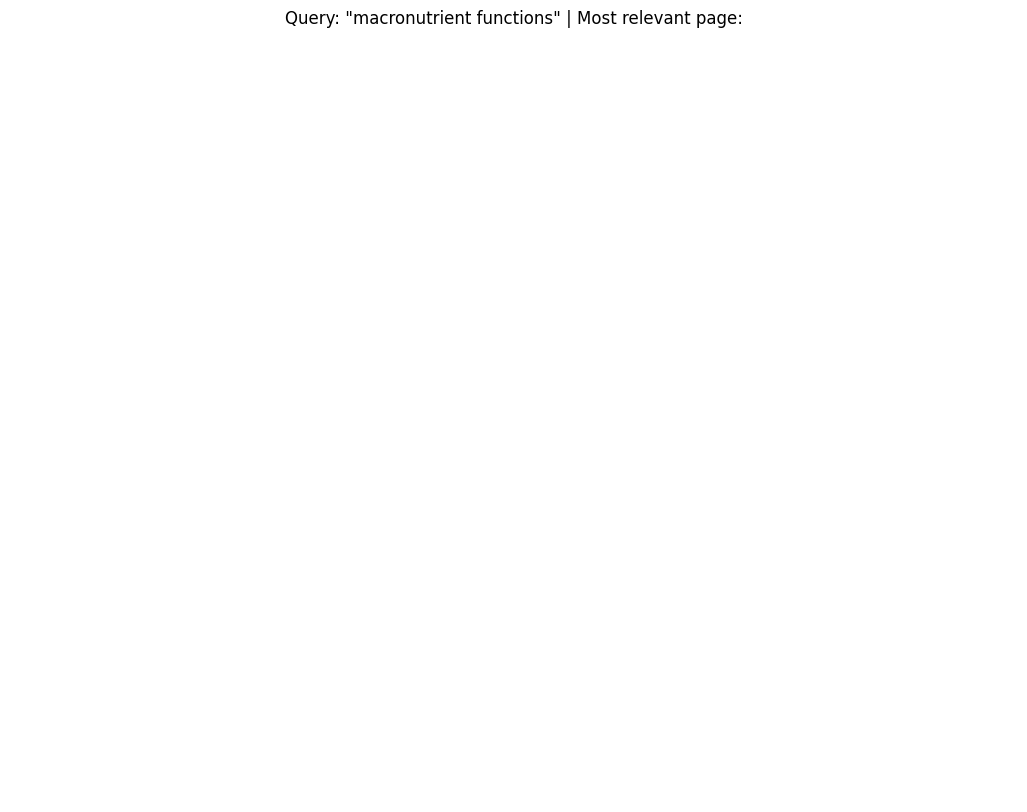

In [46]:
import fitz # pymupdf library

# open PDF and load target
pdf_path = 'human-nutrition-text.pdf'
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # note: page numbers of the pdf start 41+

# get the image of the page
img = page.get_pixmap(dpi=300)

# save image
# img.save('output_filename.png')
doc.close()

# convert the pixmap to numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.title(f'Query: "{query}" | Most relevant page:')
plt.axis(False)
plt.show()

### Similarity Measures: Dot Product & Cosine Similarity

Two of the most common similarity measures between vectors are: dot-product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

Vectors have directions (which way is it going?) and magnitude (how long is it?).

In [47]:
embeddings[0].shape # high in dimension - 768

torch.Size([768])

In [48]:
import torch

def dot_product(vector1, vector2):
  return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
  dot_product = torch.dot(vector1, vector2)

  # euclidean / l2 norm
  norm_vector1 = torch.sqrt(torch.sum(vector1 ** 2))
  norm_vector2 = torch.sqrt(torch.sum(vector2 ** 2))

  return dot_product / (norm_vector1 * norm_vector2)

# example vectors / tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# calculate dot product
print('Dot product of vector1 and vector2:', dot_product(vector1, vector2))
print('Dot product of vector1 and vector3: ', dot_product(vector1, vector3))
print('Dot product of vector1 and vector4: ', dot_product(vector1, vector4))

# cosine similarity
print('Cosine similarity between vector1 and vector2:', cosine_similarity(vector1, vector2))
print('Cosine similarity between vector1 and vector3: ', cosine_similarity(vector1, vector3))
print('Cosine similarity between vector1 and vector4: ', cosine_similarity(vector1, vector4))

Dot product of vector1 and vector2: tensor(14.)
Dot product of vector1 and vector3:  tensor(32.)
Dot product of vector1 and vector4:  tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3:  tensor(0.9746)
Cosine similarity between vector1 and vector4:  tensor(-1.0000)


In [49]:
embedding_model.encode('apple') # already normalized (if not, use cosine similarity as cosine similarity normalizes it)

array([-9.46064759e-03,  3.96859075e-04,  7.04952166e-04, -5.57546392e-02,
        3.68821174e-02, -1.42102949e-02,  2.93006431e-02, -2.73597687e-02,
        1.56488083e-02,  3.86173808e-04,  1.87518019e-02,  3.87523100e-02,
        2.46236958e-02,  1.13469306e-02, -3.10209263e-02,  5.15040085e-02,
        4.15051579e-02,  6.28838688e-02, -1.48668075e-02, -1.35560594e-02,
       -3.19223590e-02,  2.60984059e-02,  4.80279103e-02, -2.68271677e-02,
       -5.84265478e-02, -3.15050855e-02, -1.20052798e-02,  1.02869999e-02,
        1.05172964e-02,  7.83898216e-03,  1.91896744e-02, -3.04472093e-02,
       -6.38054982e-02, -7.01911747e-03,  2.07414996e-06,  9.71805025e-03,
        3.52092646e-02, -1.37234880e-02, -1.32206567e-02,  5.72632924e-02,
        1.46921892e-02,  6.56851009e-02, -3.91312912e-02,  4.25485410e-02,
       -3.34236994e-02, -1.74024925e-02,  1.38752190e-02,  1.75152794e-02,
        3.20116840e-02,  2.01448333e-02, -3.05142645e-02, -4.11942787e-02,
       -4.37280051e-02,  

### Functionizing the Semantic Search Pipeline (Retrieval)

Put *all of the steps above* for *semantic search* into a function so that the work flow can be repeated.

In [50]:
def retrieve_relevant_resources(query:str,
                                embeddings:torch.tensor,
                                model:SentenceTransformer=embedding_model,
                                n_resources_to_return:int=5,
                                print_time:bool=True):
  '''Embeds a query with model and returns top k scores and indices from embeddings'''

  # Embed the query
  query_embedding = model.encode(query, convert_to_tensor=True).to(device)

  # Get dot product scores on embeddings
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()

  if print_time:
    print(f'[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.')

  scores, indices = torch.topk(input=dot_scores,
                               k = n_resources_to_return)

  return scores, indices

def print_top_results_and_scores(query:str,
                                 embeddings:torch.tensor,
                                 pages_and_chunks:list[dict]=pages_and_chunks,
                                 n_resources_to_return:int=5):
  '''
  Finds relevant passages given a query and prints them out along with their scores.
  '''
  scores, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings,
                                                n_resources_to_return=n_resources_to_return)

  # Loop through zipped together scores and indices from torhc.topk
  for score, idx in zip(scores, indices):
    print(f'Score: {score:.4f}')
    print('Text:')
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f"Page number: {pages_and_chunks[idx]['page_no']}")
    print()

In [51]:
query = 'foods in high fibre'
# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00010 seconds.
Score: 0.6693
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a
few dietary sources of them are whole-grain foods, flax, cauliflower, and
avocados. Cellulose is the most abundant fiber in plants, making up the cell
walls and providing structure. Soluble fibers are more easily accessible to
bacterial enzymes in the large intestine so they can be broken down to a greater
extent than insoluble fibers, but even some breakdown of cellulose and other
insoluble fibers occurs. The last class of fiber is functional fiber. Functional
fibers have been added to foods and have been shown to provide health benefits
to humans. Functional fibers may be extracted from plants and purified or
synthetically made. An example of a functional fiber i

### Getting an LLM for local generation

We want to focus on local generation.

However, this process will also work with an LLM API.

What is a generative LLM?

Goes from text input -> generate text output.

Which LLM should I use?

* How much hardware VRAM have available?

### Checking local GPU memory availability

In [55]:
import torch

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f'Available GPU memory: {gpu_memory_gb} GB')

Available GPU memory: 15 GB


Note:

* To use `gemma-7b-it` or other Gemma models, the T&C has to be accepted on hugging face.
* To download models and run locally from Hugging Face, may need to sign in to hugging face from cli.

In [56]:
!pip install -U "huggingface_hub[cli]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 2.7 MB/s eta 0:00:00


In [58]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in c

In [59]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading a LLM locally

We can load an LLM locally using Hugging Face `transformers`.

To get a model running locally, requires:
1. A quantization config (optional) - a config on what precision to load the model in (eg. 8bit, 4bit, etc)
2. A model ID - this will tell transformers which model / tokenizer to load
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model), tokenizer is **specific** to the LLM.
4. An LLM model - this will be what is used to generate text based on an input.

> **Note**: There are many tips and tricks on loading/making LLMs work faster. One of the best ones is the `flash_attn (Flash Attention 2)`. FA2 is a faster implementation of token generation of large language model (faster of attention modules of Transformers).

In [ ]:
!pip install transformers

In [61]:
!pip install bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 6.1 MB/s eta 0:00:00


In [64]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM # automatically create tokenizer & based on the input & causally generate a new output
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a computer capability score of 8.0+ (Ampere, Ada Lovelace, Hopper, and above)
if (is_flash_attn_2_available() and
    torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = 'flash_attention_2'
else:
  attn_implementation = 'sdpa' # scaled dot product attention
print(f'Using attention implementation: {attn_implementation}')

# 2. Pick a model we'd like to use
model_id = model_id # google/gemma-2b-it

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory as we can
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
  llm_model.to('cuda')

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/tokenizer_config.json


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/config.json
Model config GemmaConfig {
  "_name_or_path": "google/gemma-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_activation": null,
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "torch_dtype": "float16",
  "transformers_version": "4.44.2",
  "use_cache": true,
  "vocab_size": 256000
}



model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/model.safetensors.index.json


model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Instantiating GemmaForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "eos_token_id": 1,
  "pad_token_id": 0
}

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing GemmaForCausalLM.

All the weights of GemmaForCausalLM were initialized from the model checkpoint at google/gemma-2b-it.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GemmaForCausalLM for predictions without further training.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/4cf79afa15bef73c0b98ff5937d8e57d6071ef71/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "eos_token_id": 1,
  "pad_token_id": 0
}



In [66]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [67]:
def get_model_num_params(model:torch.nn.Module):
  return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [69]:
def get_model_mem_size(model:torch.nn.Module):
  # Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

  # Calculate model sizes
  model_mem_bytes = mem_params + mem_buffers
  model_mem_mb = model_mem_bytes / (1024 ** 2)
  model_mem_gb = model_mem_bytes / (1024 ** 3)

  return {'model_mem_bytes': model_mem_bytes,
          'model_mem_mb': round(model_mem_mb, 2),
          'model_mem_gb': round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

This means to load Gemma 2b-it in float16, we need a minimum of 4.67GB of VRAM, however, due to the claculations that take place in the forward pass, we actually need closer to 8GB.

### Generate text with our LLM